In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For scraping reviews in google play
# !pip install -q google_play_scraper
from google_play_scraper import app, Sort, reviews_all

# For sentiment analysis
# !pip install -q transformers
from transformers import pipeline
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
!pip install -q pyyaml==5.4.1


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Exploratory Data Analysis

## Load the preprocessed dataset

### Lazada

In [4]:
lazada_reviews_clean_df = pd.read_csv('../Data/lazada_reviews_clean.csv', parse_dates = ['at', 'repliedAt'])

In [5]:
lazada_reviews_clean_df.shape

(336202, 12)

The scraped dataset initially included 788257 rows; however, following preprocessing, which included deleting duplicate user reviews and filtering reviews, the dataset currently only has 336202 rows.

In [6]:
lazada_reviews_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336202 entries, 0 to 336201
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              336202 non-null  object        
 1   userName              336201 non-null  object        
 2   userImage             336202 non-null  object        
 3   content               336202 non-null  object        
 4   contentAdj            336202 non-null  object        
 5   score                 336202 non-null  int64         
 6   thumbsUpCount         336202 non-null  int64         
 7   reviewCreatedVersion  262882 non-null  object        
 8   at                    336202 non-null  datetime64[ns]
 9   replyContent          125853 non-null  object        
 10  repliedAt             125853 non-null  datetime64[ns]
 11  appVersion            262882 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 30

In [7]:
lazada_reviews_clean_df.isnull().sum()

reviewId                     0
userName                     1
userImage                    0
content                      0
contentAdj                   0
score                        0
thumbsUpCount                0
reviewCreatedVersion     73320
at                           0
replyContent            210349
repliedAt               210349
appVersion               73320
dtype: int64

A possible reason that the 4 columns have missing values are because of Google Play Store not tagging the reviewCreatedVersion and appVersion and for the platform side the app creator did not reply to the user review.

In [8]:
lazada_reviews_clean_df.describe()

,score,thumbsUpCount,at,repliedAt
count,336202.000000,336202.000000,336202,125853
mean,4.100490,2.662863,2020-04-09 19:11:28.611640832,2019-11-25 16:26:41.180583936
min,1.000000,0.000000,2013-06-09 08:34:37,2013-06-14 09:49:23
25%,4.000000,0.000000,2019-03-18 07:39:36.249999872,2017-10-23 00:32:05
50%,5.000000,0.000000,2020-05-12 14:32:03,2018-12-04 14:16:09
75%,5.000000,0.000000,2021-08-14 11:01:18.750000128,2022-08-17 09:07:09
max,5.000000,12635.000000,2023-09-29 04:18:45,2023-09-29 06:27:50
std,1.494043,62.670629,NaN,NaN


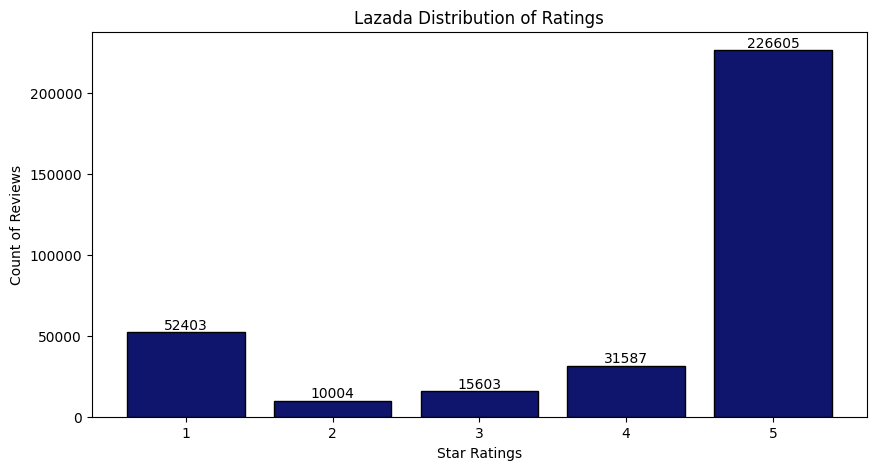

In [9]:
lazada_star_counts = lazada_reviews_clean_df['score'].value_counts().sort_index()
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(lazada_star_counts.index, lazada_star_counts, color='#0f146d', edgecolor='black')
ax1.set_title('Lazada Distribution of Ratings')
ax1.set_xlabel('Star Ratings')
ax1.set_ylabel('Count of Reviews')
ax1.set_xticks(lazada_star_counts.index)
ax1.set_xticklabels(lazada_star_counts.index)

for i, count in enumerate(lazada_star_counts):
    ax1.text(lazada_star_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

### Shopee

In [10]:
shopee_reviews_clean_df = pd.read_csv('../Data/shopee_reviews_clean.csv', parse_dates = ['at', 'repliedAt'])

In [11]:
shopee_reviews_clean_df.shape

(155583, 12)

The original rows in the scraped dataset were 316410 now after going through preprocessing removing duplicate reviews from users and filtering reviews it has now shrunk to a size of 155583.

In [12]:
shopee_reviews_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155583 entries, 0 to 155582
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              155583 non-null  object        
 1   userName              155583 non-null  object        
 2   userImage             155583 non-null  object        
 3   content               155583 non-null  object        
 4   contentAdj            155583 non-null  object        
 5   score                 155583 non-null  int64         
 6   thumbsUpCount         155583 non-null  int64         
 7   reviewCreatedVersion  122714 non-null  object        
 8   at                    155583 non-null  datetime64[ns]
 9   replyContent          73867 non-null   object        
 10  repliedAt             73868 non-null   datetime64[ns]
 11  appVersion            122714 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 14

In [13]:
shopee_reviews_clean_df.isnull().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
contentAdj                  0
score                       0
thumbsUpCount               0
reviewCreatedVersion    32869
at                          0
replyContent            81716
repliedAt               81715
appVersion              32869
dtype: int64

Same case here for the missing values.

In [14]:
shopee_reviews_clean_df.describe()

,score,thumbsUpCount,at,repliedAt
count,155583.000000,155583.000000,155583,73868
mean,3.903627,2.656556,2022-05-06 12:05:00.975312128,2021-12-01 04:45:48.469743104
min,1.000000,0.000000,2021-06-15 09:15:04,2016-01-06 07:12:06
25%,3.000000,0.000000,2021-10-31 10:13:43.500000,2021-08-24 13:17:09
50%,5.000000,0.000000,2022-03-23 01:59:32,2021-11-25 04:52:48
75%,5.000000,0.000000,2022-09-30 17:11:40.500000,2022-03-30 13:14:07
max,5.000000,19734.000000,2023-09-29 05:58:25,2022-09-26 02:56:58
std,1.659658,87.496708,NaN,NaN


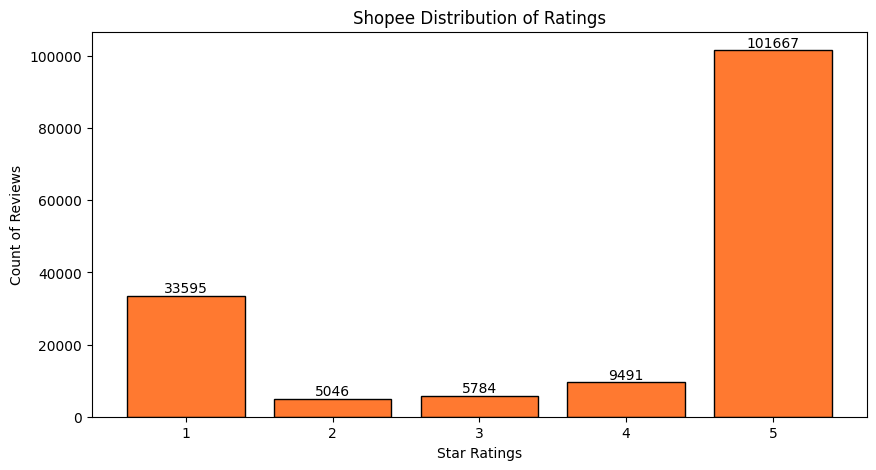

In [15]:
shopee_star_counts = shopee_reviews_clean_df['score'].value_counts().sort_index()
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.bar(shopee_star_counts.index, shopee_star_counts, color='#ff7930', edgecolor='black')
ax2.set_title('Shopee Distribution of Ratings')
ax2.set_xlabel('Star Ratings')
ax2.set_ylabel('Count of Reviews')
ax2.set_xticks(shopee_star_counts.index)
ax2.set_xticklabels(shopee_star_counts.index)

for i, count in enumerate(shopee_star_counts):
    ax2.text(shopee_star_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

# Drawing Key Insights

## Distribution of reviews according to when they were made

### Lazada

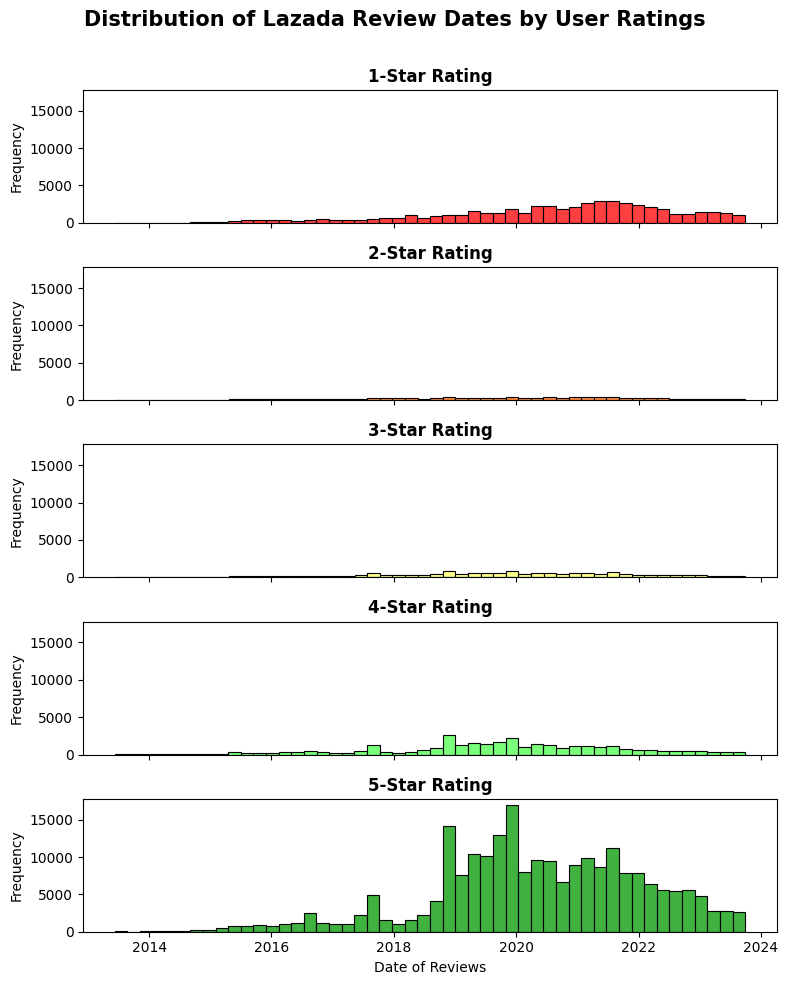

In [16]:
def laz_subplot_histograms(main_title, list_of_titles, xlabels, list_of_colors):
    fig, ax = plt.subplots(5, 1, figsize=(8, 10), sharex=True, sharey=True)
    for i in range(5):
        sns.histplot(
            data=lazada_reviews_clean_df[lazada_reviews_clean_df['score'] == (i + 1)],
            x='at',
            bins=50,
            color=list_of_colors[i],
            ax=ax[i]
        )
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')

    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

laz_subplot_histograms(
    main_title="Distribution of Lazada Review Dates by User Ratings",
    list_of_titles=['1-Star Rating', '2-Star Rating', '3-Star Rating', '4-Star Rating', '5-Star Rating'],
    xlabels='Date of Reviews',
    list_of_colors=['#fe0000', '#ff6500', '#ffff66', '#4cff4c', '#009900']
)

The distribution of reviews by user rating in Lazada go way back in 2013 in which it started off with mainly positive reviews.

### Shopee

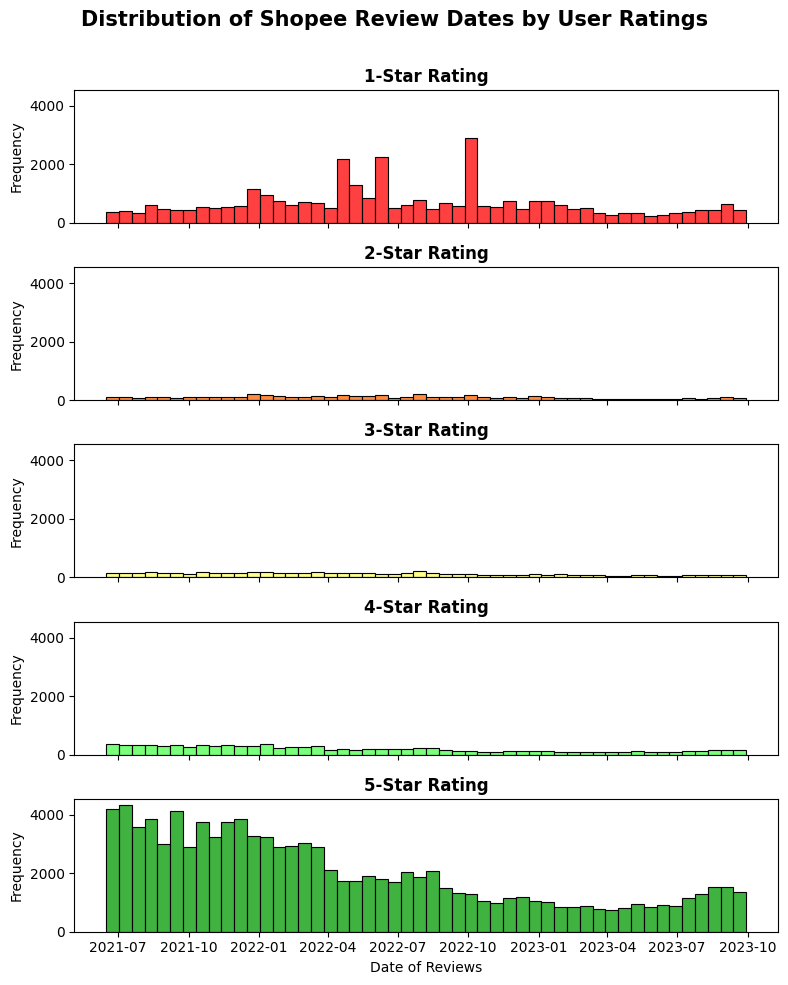

In [17]:
def shopee_subplot_histograms(main_title, list_of_titles, xlabels, list_of_colors):
    fig, ax = plt.subplots(5, 1, figsize=(8, 10), sharex=True, sharey=True)
    for i in range(5):
        sns.histplot(
            data=shopee_reviews_clean_df[shopee_reviews_clean_df['score'] == (i + 1)],
            x='at',
            bins=50,
            color=list_of_colors[i],
            ax=ax[i]
        )
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')

    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

shopee_subplot_histograms(
    main_title="Distribution of Shopee Review Dates by User Ratings",
    list_of_titles=['1-Star Rating', '2-Star Rating', '3-Star Rating', '4-Star Rating', '5-Star Rating'],
    xlabels='Date of Reviews',
    list_of_colors=['#fe0000', '#ff6500', '#ffff66', '#4cff4c', '#009900']
)


The distribution of reviews by user rating in Shopee unfortunately go back only to 2021 this might be because of the data being scraped.

## 

## What trends could be seen over time based on the reviews

### Lazada

In [18]:
# Extract year, quarter, month, week, day of month and day of week from at column
lazada_reviews_clean_df['Year'] = lazada_reviews_clean_df['at'].dt.year
lazada_reviews_clean_df['Quarter'] = lazada_reviews_clean_df['at'].dt.quarter
lazada_reviews_clean_df['Month'] = lazada_reviews_clean_df['at'].dt.month
lazada_reviews_clean_df['Day'] = lazada_reviews_clean_df['at'].dt.day

In [19]:
def generate_reviews_trend_plot(x_value, title, xlabel, df):
    plt.figure(figsize=(20, 6))
    ax = sns.countplot(y=x_value, data=df, color='#0f146d')

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', xytext=(5, 0), 
                    textcoords='offset points')

    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(xlabel)
    plt.show()

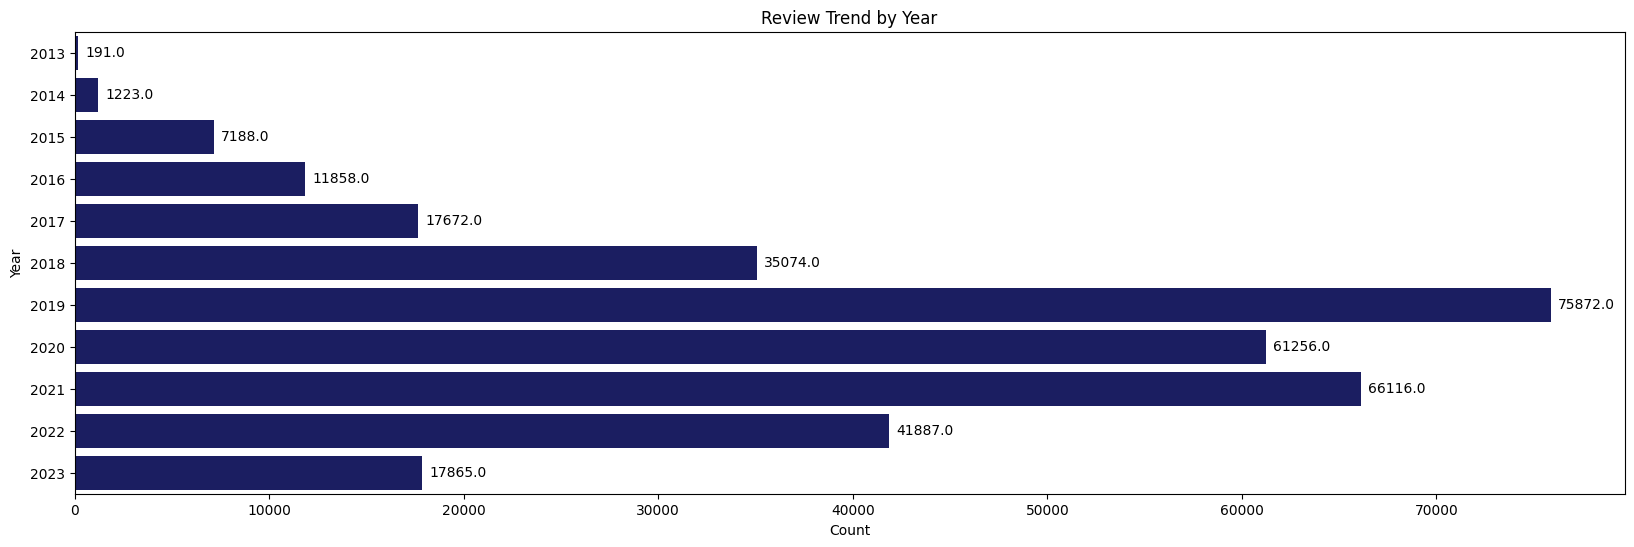

In [20]:
generate_reviews_trend_plot("Year", "Review Trend by Year", "Year", lazada_reviews_clean_df)

2019 is the year with the most concentration of reviews with a count of 75872. This is followed by the year 2021 with 66116 and year 2020 with 61256.

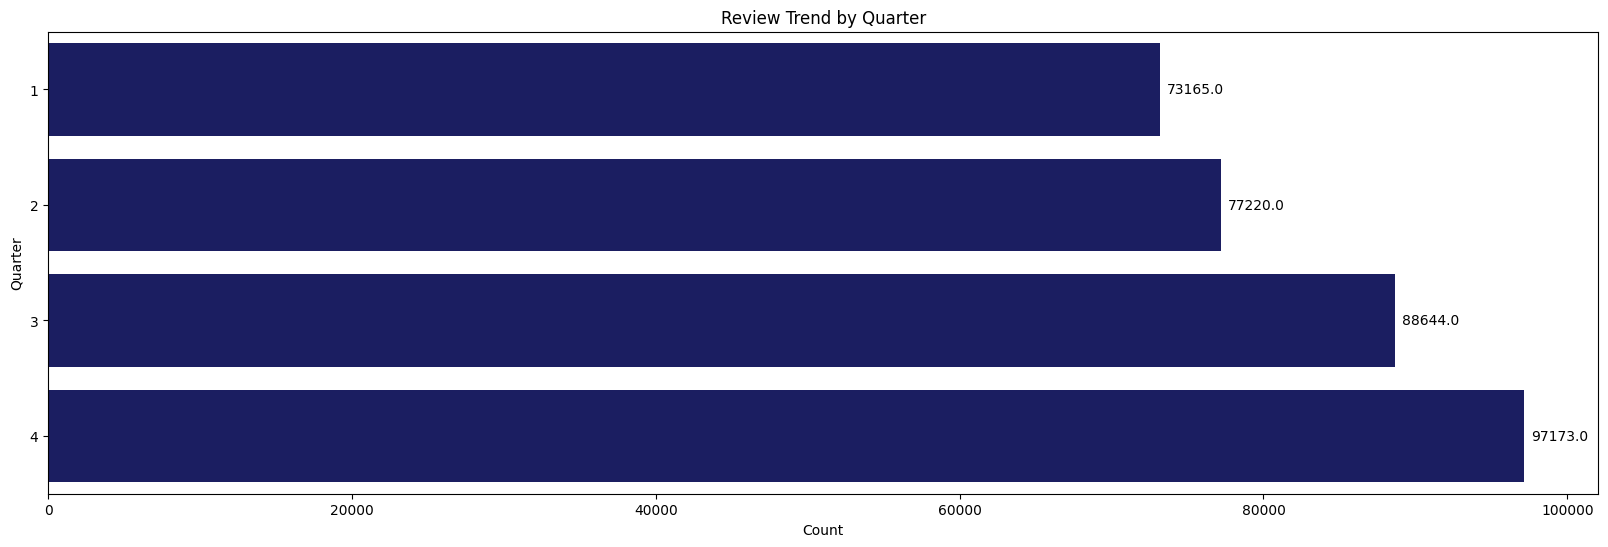

In [21]:
generate_reviews_trend_plot("Quarter", "Review Trend by Quarter", "Quarter", lazada_reviews_clean_df)

At the 4th quarter is when the most reviews are made with a count of 97173 reviews. This may be attributed to users recieving some of their work benefits like 13th month pay or christmas bunos as well as christmas money of the younger demographic thus making users buy stuff online.

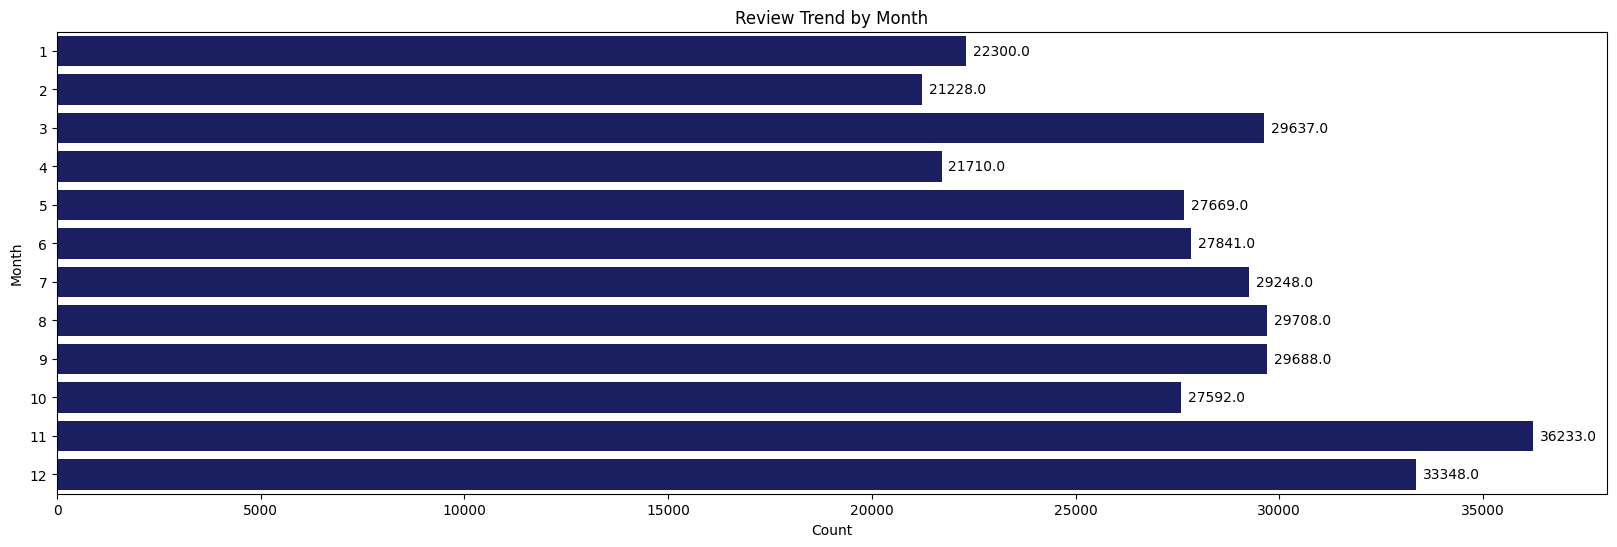

In [22]:
generate_reviews_trend_plot("Month", "Review Trend by Month", "Month", lazada_reviews_clean_df)

The most number of reviews made was in the month of November with a count of 36233. This aligns with the previos trend that at the 4th quarter has the most reviews generated.

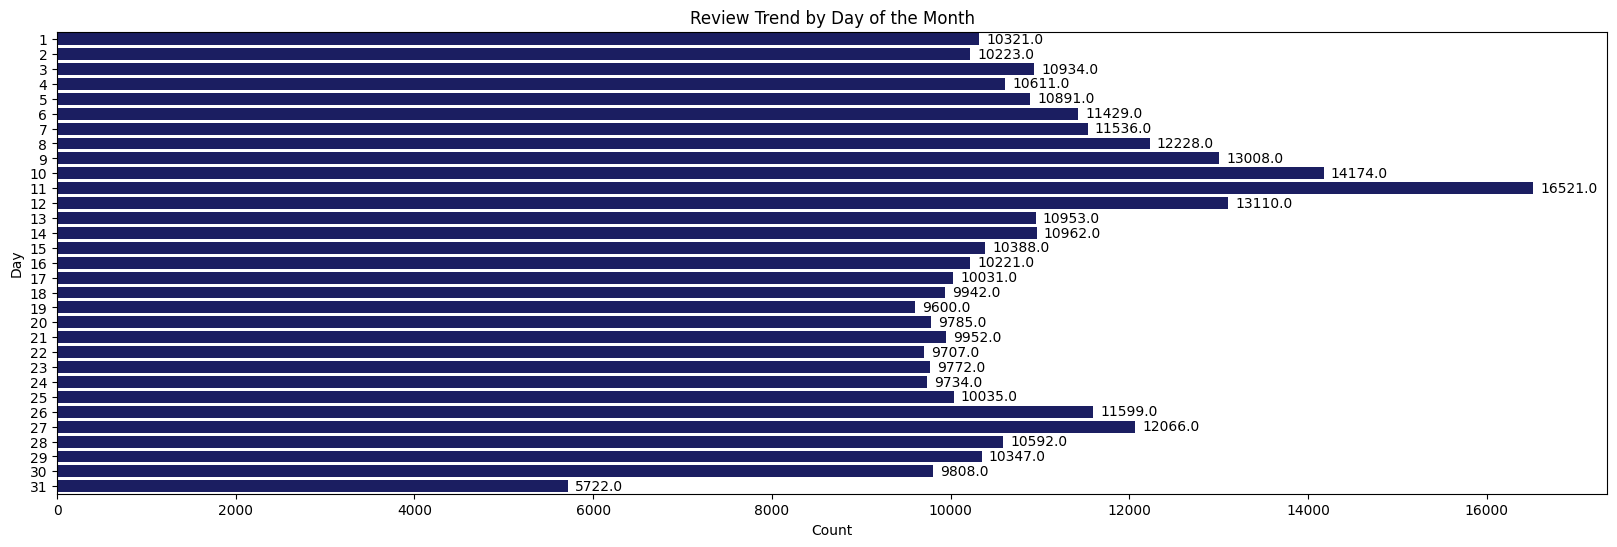

In [23]:
generate_reviews_trend_plot("Day", "Review Trend by Day of the Month", "Day", lazada_reviews_clean_df)

It was during the 11th day of the month reviews are made the highest with a count of 16521. A large concentration of the reviews are made around that day this is because of Lazadas monthly sale. There were not many reviews made in the 31st day of the month since other months have a 31st day.

The peak in reviews occurred during November 2019, particularly on the 11th day of that month, coinciding with Lazada's significant sales events. Lazada is known for its monthly sales, adopting a format where the day matches the month number (e.g., 1.1 for January, 2.2 for February). During these events, products are offered at discounted rates, accompanied by free shipping vouchers, cashback, and Lazada bonuses, making it the best time for consumers to make purchases. This surge in reviews during sales periods suggests a correlation between consumer feedback and the occurrence of these promotional events, indicating levels of satisfaction or dissatisfaction. Does it mean that during other years, the same trend could be seen? In my opinion, I don't think so, because drilling down into other years will provide insights into that specific year, but this overall top-down view of the whole review trend provides a good surface-level view of the analysis.

### Shopee

In [24]:
# Extract year, quarter, month, week, day of month and day of week from at column
shopee_reviews_clean_df['Year'] = shopee_reviews_clean_df['at'].dt.year
shopee_reviews_clean_df['Quarter'] = shopee_reviews_clean_df['at'].dt.quarter
shopee_reviews_clean_df['Month'] = shopee_reviews_clean_df['at'].dt.month
shopee_reviews_clean_df['Day'] = shopee_reviews_clean_df['at'].dt.day

In [25]:
def generate_reviews_trend_plot(x_value, title, xlabel, df):
    plt.figure(figsize=(20, 6))
    ax = sns.countplot(y=x_value, data=df, color='#ff7930')

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', xytext=(5, 0), 
                    textcoords='offset points')

    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(xlabel)
    plt.show()

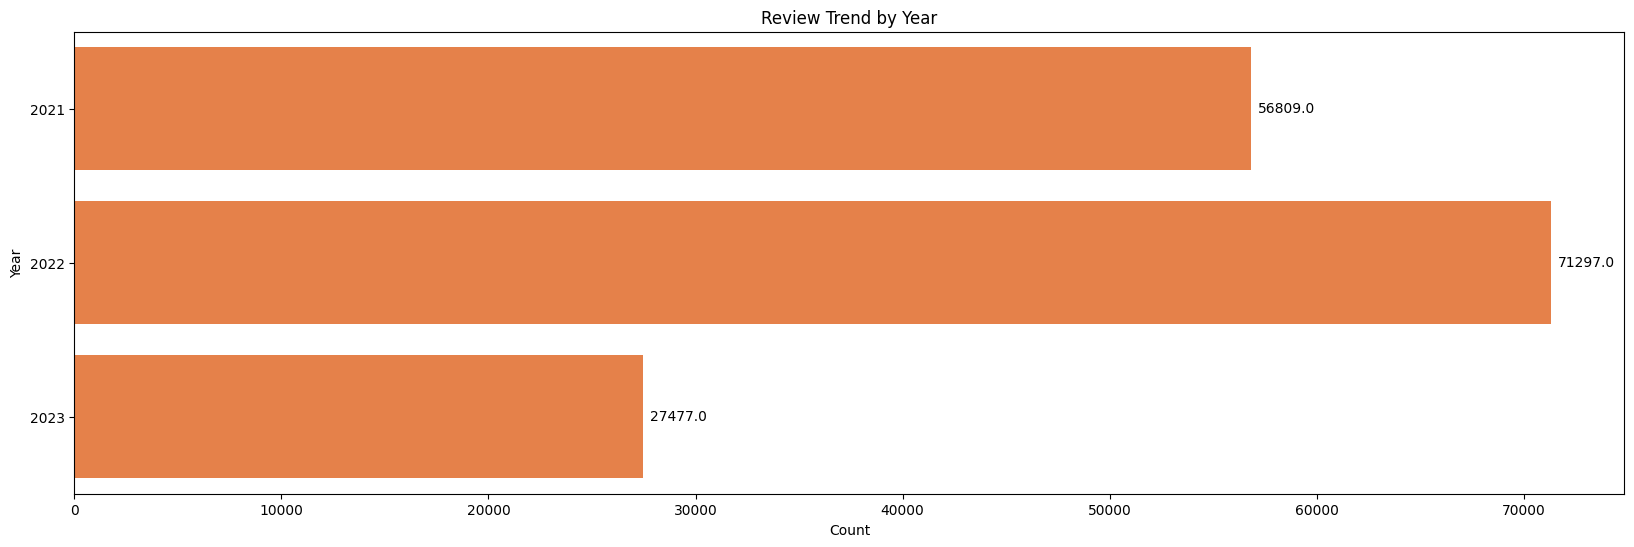

In [26]:
generate_reviews_trend_plot("Year", "Review Trend by Year", "Year", shopee_reviews_clean_df)

2022 was the year with the most reviews, with a count of 71297.

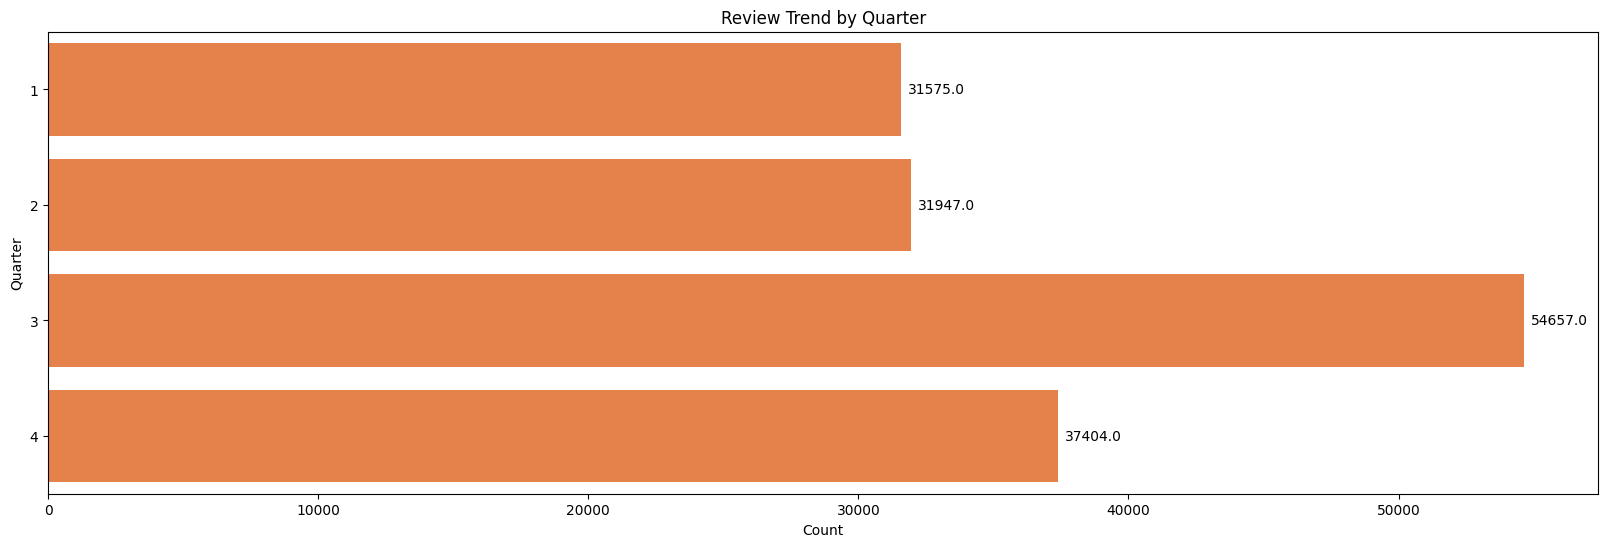

In [27]:
generate_reviews_trend_plot("Quarter", "Review Trend by Quarter", "Quarter", shopee_reviews_clean_df)

The quarter where the most reviews were made was in the 3rd quarter with a count of 54657.

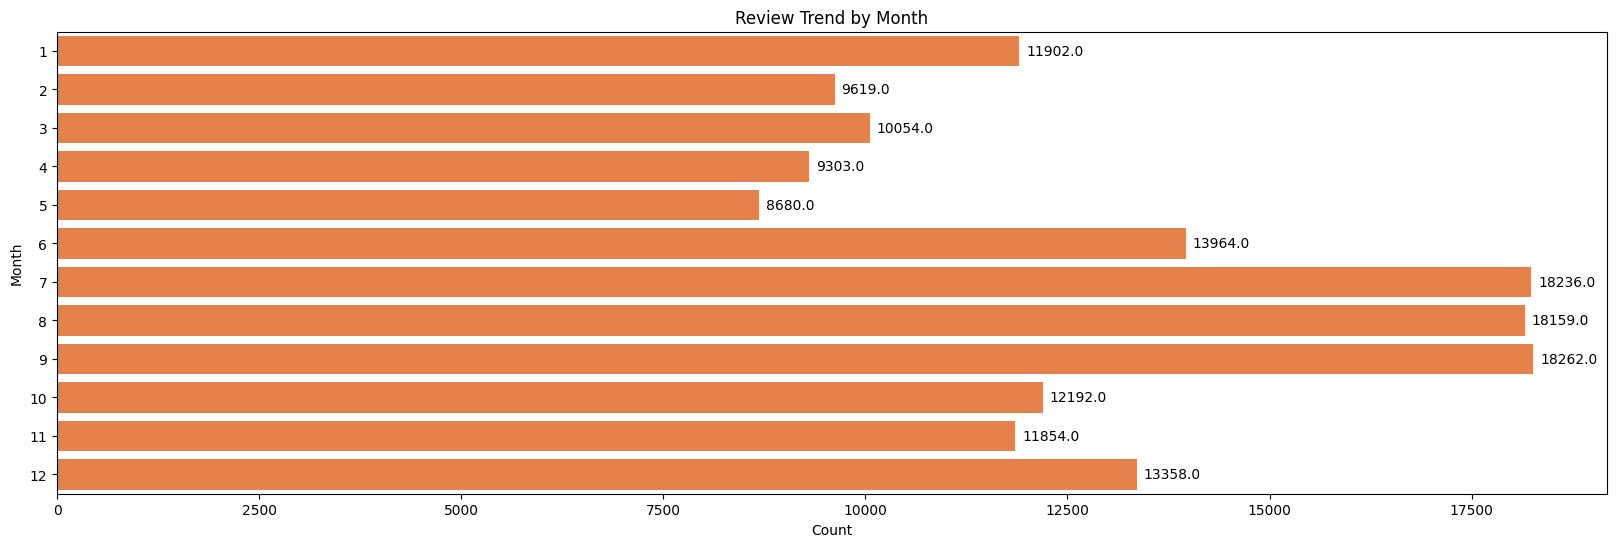

In [28]:
generate_reviews_trend_plot("Month", "Review Trend by Month", "Month", shopee_reviews_clean_df)

The monthly trend aligns with the quarterly trend, in which the month where the most reviews were generated was during August (18262), July (18236), and August (18159).

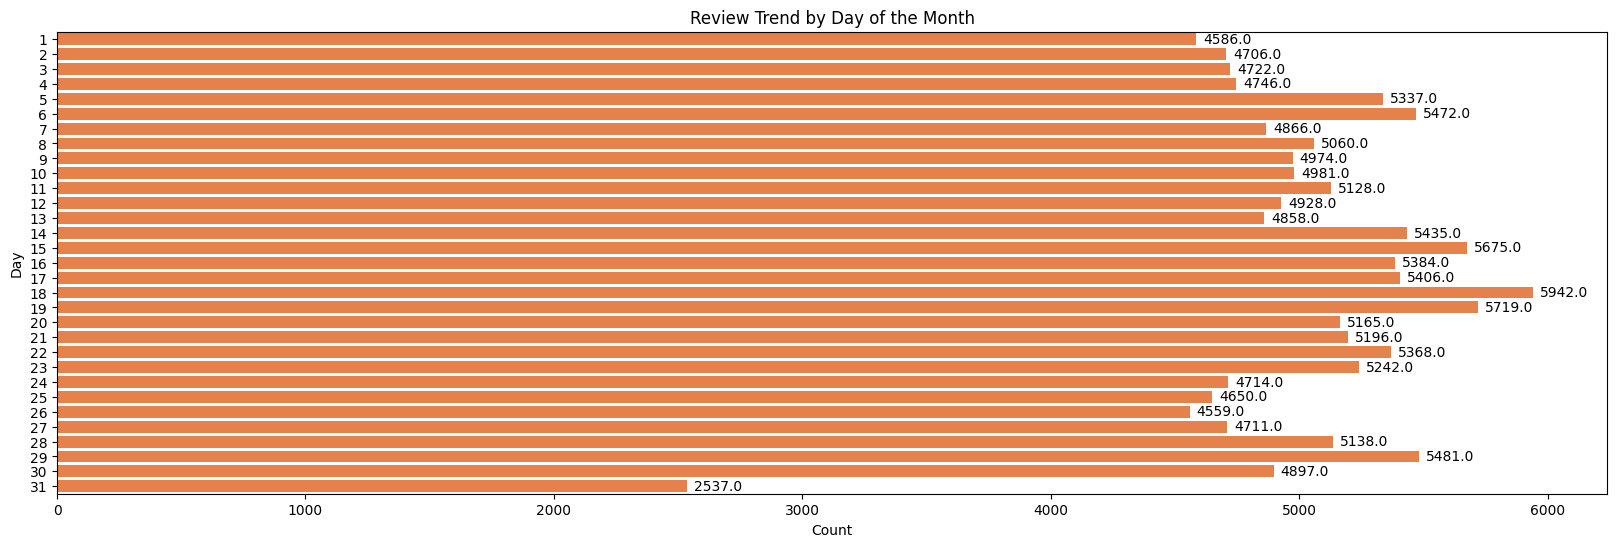

In [29]:
generate_reviews_trend_plot("Day", "Review Trend by Day of the Month", "Day", shopee_reviews_clean_df)

It was on the 18th day of the month that the most reviews were generated, with a count of 5942. There were some notable days of the month where reviews were generated, for instance, during the start of the month, in the middle of the month, and at the end of the month, more reviews were made compared to other days. Reviews were lowest at the 31st day since again some months don't have a 31st day.

In 2022, reviews surged to a total of 71,297, peaking notably in the 3rd quarter with 54,657 reviews, particularly in August, July, and September (18,262, 18,236, and 18,159, respectively). The 18th day of each month notably stood out as the peak day with 5,942 reviews, while review spikes were also noticeable at the start, middle, and end of the month. These fluctuations appear to align with both quarterly and yearly trends in review activity. Shopee's diverse range of sales events, including Shopee Flash Sale, ShopeePay Exclusives, Lowest Price Guaranteed, Shopee Double Double Sale, and Shopee Prizes, likely contribute to the heightened activity on the platform. This could potentially correlate with observed peaks in review submissions across various periods throughout the year.

## Which reviews garnered the most number of thumbs up from their reviews both positive and negative

### Lazada

                                                 content  thumbsUpCount  score
44127  You really have to be careful when ordering st...          12635      1
53170  The app/site is getting worse. You used to hav...           9824      1
53418  The app UI is not good. It is also confusing. ...           9424      1
19528  Overall it's a really great app and is easy to...           9082      5
13466  There's just a lot of things that Lazada needs...           8752      1


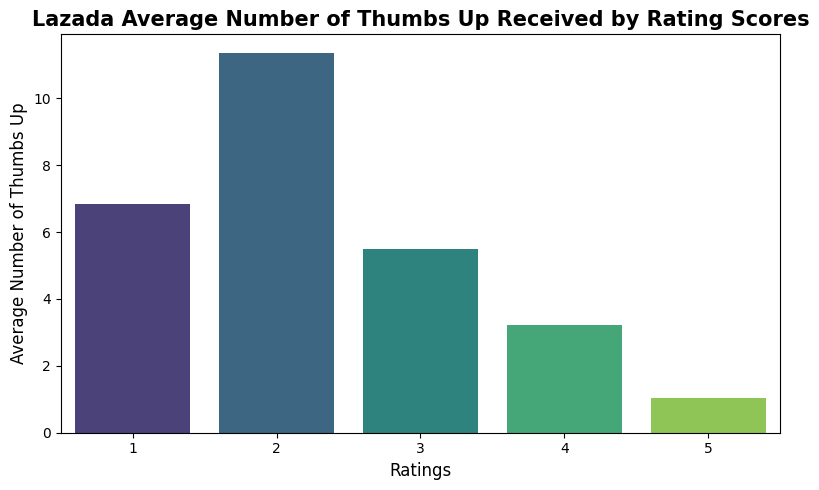

In [30]:
laz_average_thumbs_up = lazada_reviews_clean_df.groupby('score')['thumbsUpCount'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=laz_average_thumbs_up.index, y=laz_average_thumbs_up, palette="viridis")
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Average Number of Thumbs Up', fontsize=12)
plt.title('Lazada Average Number of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout()
laz_top_rated_content = lazada_reviews_clean_df[['content', 'thumbsUpCount', 'score']].sort_values(by='thumbsUpCount', ascending=False).head()
print(laz_top_rated_content)

Based on Lazada reviews, negative ratings tend to receive more thumbs up on average, than positive ratings.

### Shopee

                                                 content  thumbsUpCount  score
18762  It's kind of frustrating when you try to find ...          19734      1
15730  Been using this app for years now, and other t...          14085      4
22541  1. Cannot view photos when you check on the it...          10877      1
54041  The app is good for the most part. However, on...           6796      3
76365  Unsatisfactory Overall. The search engine disp...           6650      2


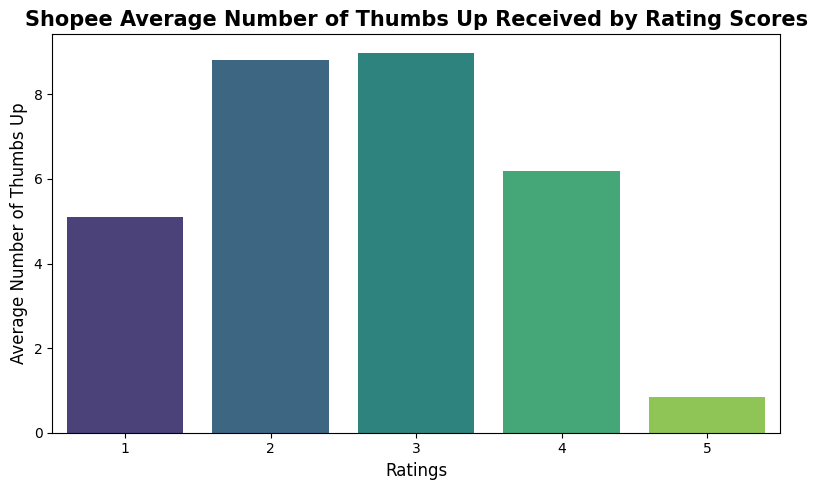

In [31]:
shopee_average_thumbs_up = shopee_reviews_clean_df.groupby('score')['thumbsUpCount'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=shopee_average_thumbs_up.index, y=shopee_average_thumbs_up, palette="viridis")
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Average Number of Thumbs Up', fontsize=12)
plt.title('Shopee Average Number of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout()
shopee_top_rated_content = shopee_reviews_clean_df[['content', 'thumbsUpCount', 'score']].sort_values(by='thumbsUpCount', ascending=False).head()
print(shopee_top_rated_content)

The same trend can be seen with Shopee reviews, in which negative ratings tend to receive more thumbs up on average than positive ratings.

## Most frequently used words for both reviews

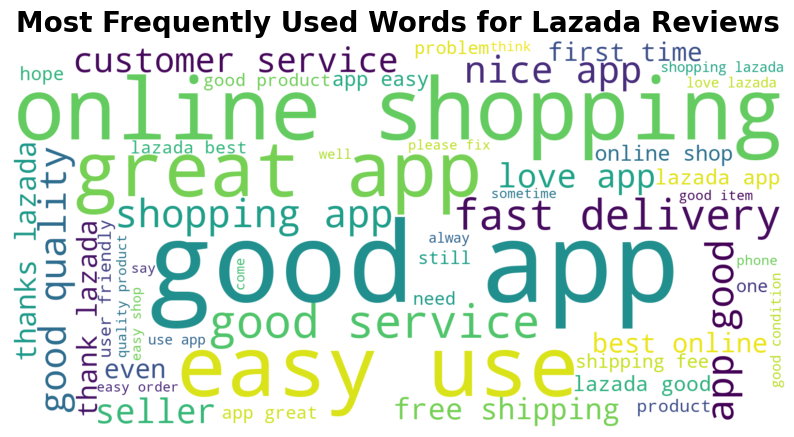

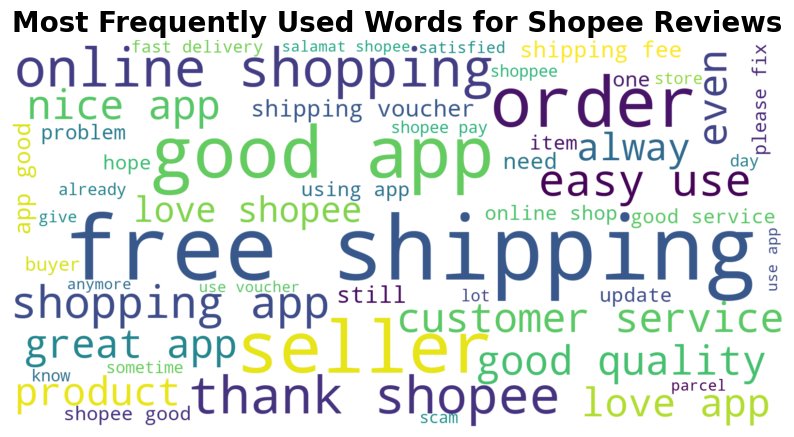

In [32]:
lazada_text = lazada_reviews_clean_df['contentAdj'].str.cat(sep=' ')
shopee_text = shopee_reviews_clean_df['contentAdj'].str.cat(sep=' ')

lazada_tokens = word_tokenize(lazada_text)
shopee_tokens = word_tokenize(shopee_text)

stop_words = set(stopwords.words('english'))

# Generate word clouds
lazada_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(lazada_tokens))
shopee_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(shopee_tokens))

plt.figure(figsize=(10, 8))
plt.imshow(lazada_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Lazada Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(shopee_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Shopee Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

The frequently used words in Lazada reviews are generally positive, highlighting users' satisfaction with the app, product quality, and services. On the other hand, the frequently used words in Shopee reviews also exhibit positive sentiment, with discussions about free shipping and expressions of gratitude. I'm going to add some custom stopwords so that the a more consistent sentiment may be formed.

### Lazada

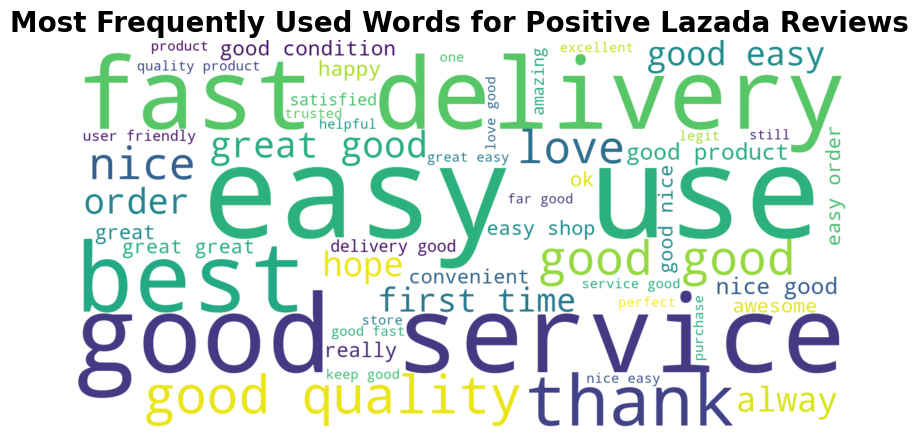

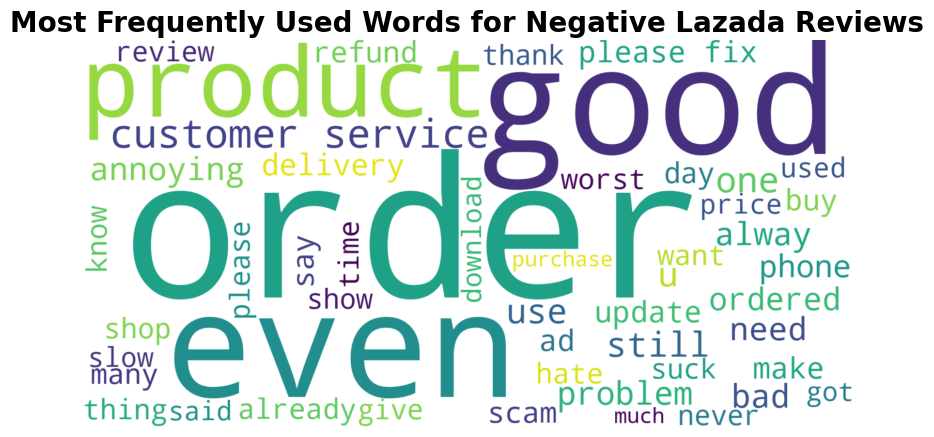

In [33]:
laz_custom_stopwords = ["lazada", "app", "apps", "seller", "online", "shopping", "fee", "item", "items", "shipping", "voucher", "free", "sellers"]
stop_words_laz = set(stopwords.words('english') + laz_custom_stopwords)

# Positive reviews for Lazada (4-5 stars)
positive_lazada_reviews = lazada_reviews_clean_df[lazada_reviews_clean_df['score'] >= 4]
positive_lazada_text = positive_lazada_reviews['contentAdj'].str.cat(sep=' ')
positive_lazada_tokens = word_tokenize(positive_lazada_text)
positive_lazada_tokens = [word for word in positive_lazada_tokens if word.lower() not in stop_words_laz]

# Negative reviews for Lazada (1-3 stars)
negative_lazada_reviews = lazada_reviews_clean_df[lazada_reviews_clean_df['score'] <= 3]
negative_lazada_text = negative_lazada_reviews['contentAdj'].str.cat(sep=' ')
negative_lazada_tokens = word_tokenize(negative_lazada_text)
negative_lazada_tokens = [word for word in negative_lazada_tokens if word.lower() not in stop_words_laz]

# Create word clouds for positive and negative reviews of Lazada
positive_lazada_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(positive_lazada_tokens))
negative_lazada_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(negative_lazada_tokens))

# Display word clouds for positive and negative reviews of Lazada
plt.figure(figsize=(10, 8))
plt.imshow(positive_lazada_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Positive Lazada Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(negative_lazada_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Negative Lazada Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

After adding some custom stopwords the word cloud is finally giving cohesive sentiments fleshing out the reviews based on positive and negative content. As we can see the most frequently used words for positive reviews mainly suggest positive qualities like the app is easy to use, good service and great. While, the most frequently used words for negative reviews are even, order, and product.

### Shopee

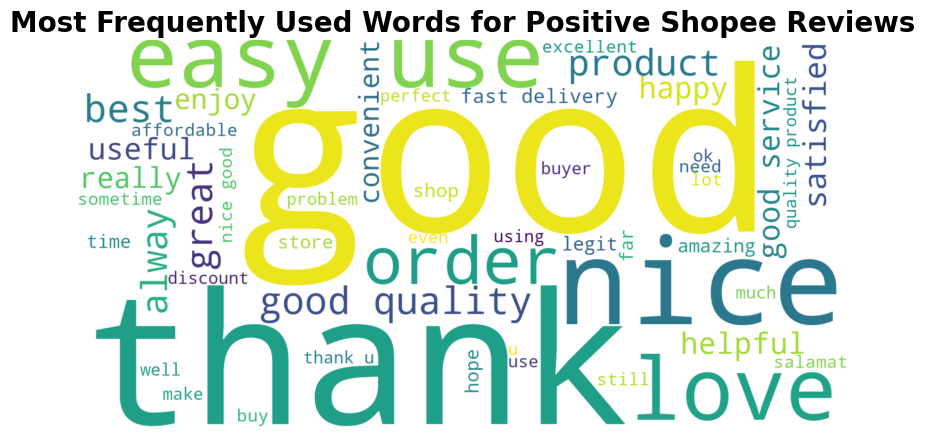

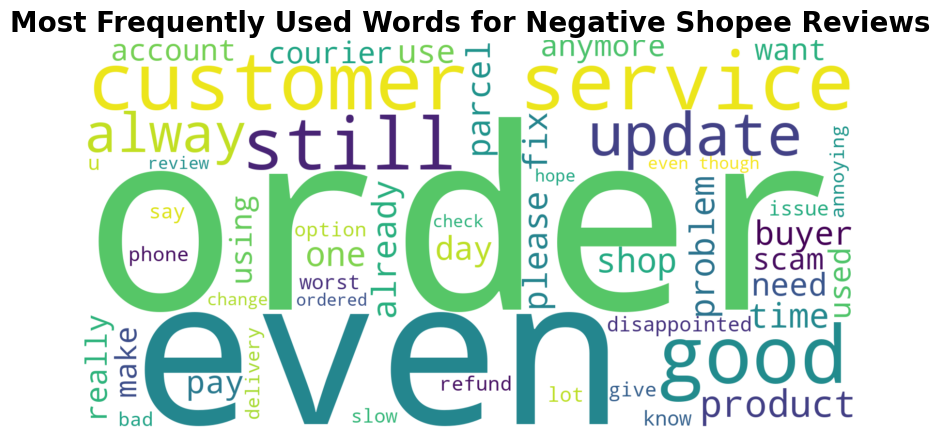

In [34]:
shopee_custom_stopwords = ["shopee", "shoppee", "shoppe", "app", "apps", "seller", "online", "shopping", "fee", "item", "items", "shipping", "voucher", "free", "sellers"]
stop_words_shopee= set(stopwords.words('english') + shopee_custom_stopwords)

# Positive reviews for Shopee (4-5 stars)
positive_shopee_reviews = shopee_reviews_clean_df[shopee_reviews_clean_df['score'] >= 4]
positive_shopee_text = positive_shopee_reviews['contentAdj'].str.cat(sep=' ')
positive_shopee_tokens = word_tokenize(positive_shopee_text)
positive_shopee_tokens = [word for word in positive_shopee_tokens if word.lower() not in stop_words_shopee]

# Negative reviews for Shopee (1-3 stars)
negative_shopee_reviews = shopee_reviews_clean_df[shopee_reviews_clean_df['score'] <= 3]
negative_shopee_text = negative_shopee_reviews['contentAdj'].str.cat(sep=' ')
negative_shopee_tokens = word_tokenize(negative_shopee_text)
negative_shopee_tokens = [word for word in negative_shopee_tokens if word.lower() not in stop_words_shopee]

# Create word clouds for positive and negative reviews of  Shopee
positive_shopee_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(positive_shopee_tokens))
negative_shopee_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=50).generate(' '.join(negative_shopee_tokens))

# Display word clouds for positive and negative reviews of Shopee
plt.figure(figsize=(10, 8))
plt.imshow(positive_shopee_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Positive Shopee Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(negative_shopee_wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Words for Negative Shopee Reviews', fontsize=20, weight='bold')
plt.axis("off")
plt.show()

Same thing with shopee by adding some custom stop words the sentiments become a lot fleshed out. The most frequently used words for positive reviews in shopee are good, thank and nice. On the other hand, the most frequently used words for negative reviews in shopee are order, even and customer service.

### What version of the app had the most positive and negative reviews

### Lazada

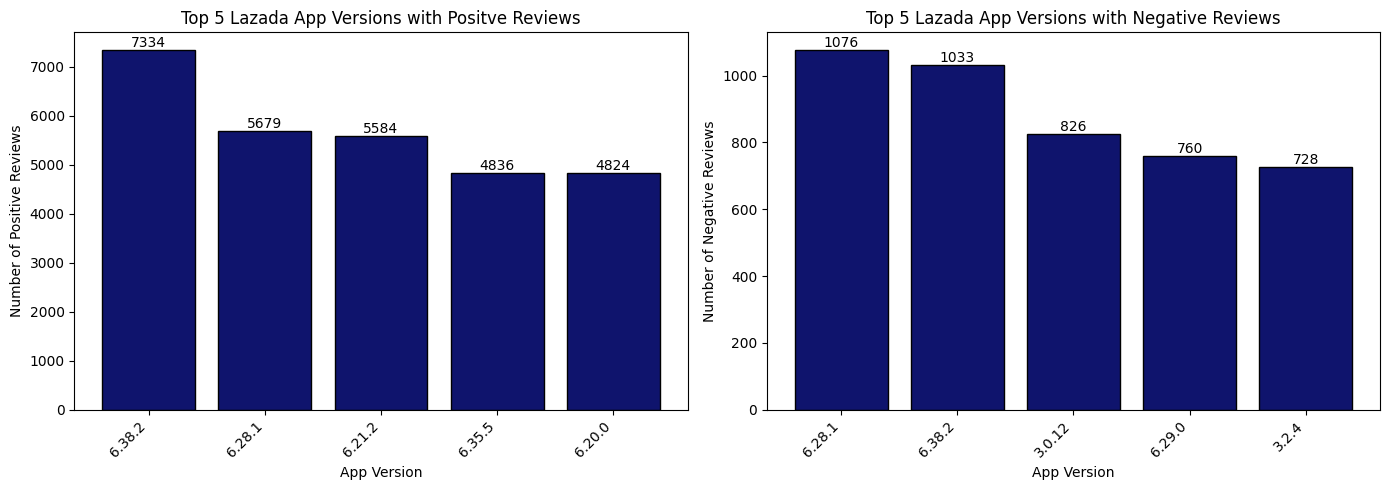

In [35]:
positive_lazada_version = lazada_reviews_clean_df[lazada_reviews_clean_df['score'] >= 4]
negative_lazada_version = lazada_reviews_clean_df[lazada_reviews_clean_df['score'] <= 3]
top_positive_lazada_app_version = positive_lazada_version['appVersion'].value_counts().nlargest(5)
top_negative_lazada_app_version = negative_lazada_version['appVersion'].value_counts().nlargest(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.bar(top_positive_lazada_app_version.index, top_positive_lazada_app_version, color='#0f146d', edgecolor='black')
ax1.set_xlabel("App Version")
ax1.set_ylabel("Number of Positive Reviews")
ax1.set_title("Top 5 Lazada App Versions with Positve Reviews")
for i, count in enumerate(top_positive_lazada_app_version):
    ax1.text(top_positive_lazada_app_version.index[i], count, str(count), ha='center', va='bottom')

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.bar(top_negative_lazada_app_version.index, top_negative_lazada_app_version, color='#0f146d', edgecolor='black')
ax2.set_xlabel("App Version")
ax2.set_ylabel("Number of Negative Reviews")
ax2.set_title("Top 5 Lazada App Versions with Negative Reviews")
for i, count in enumerate(top_negative_lazada_app_version):
    ax2.text(top_negative_lazada_app_version.index[i], count, str(count), ha='center', va='bottom')

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Lazada app version **6.38.2** had the most positive reviews, and app version **6.28.1** had the most negative reviews.

### Shopee

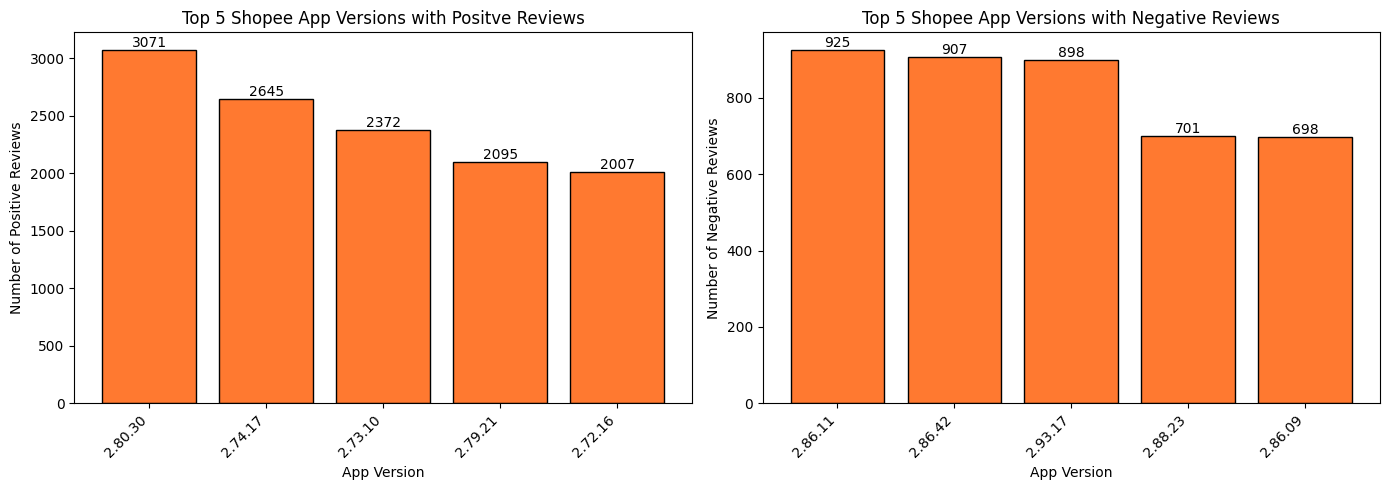

In [36]:
positive_shopee_version = shopee_reviews_clean_df[shopee_reviews_clean_df['score'] >= 4]
negative_shopee_version = shopee_reviews_clean_df[shopee_reviews_clean_df['score'] <= 3]
top_positive_shopee_app_version = positive_shopee_version['appVersion'].value_counts().nlargest(5)
top_negative_shopee_app_version = negative_shopee_version['appVersion'].value_counts().nlargest(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.bar(top_positive_shopee_app_version.index, top_positive_shopee_app_version, color='#ff7930', edgecolor='black')
ax1.set_xlabel("App Version")
ax1.set_ylabel("Number of Positive Reviews")
ax1.set_title("Top 5 Shopee App Versions with Positve Reviews")
for i, count in enumerate(top_positive_shopee_app_version):
    ax1.text(top_positive_shopee_app_version.index[i], count, str(count), ha='center', va='bottom')

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.bar(top_negative_shopee_app_version.index, top_negative_shopee_app_version, color='#ff7930', edgecolor='black')
ax2.set_xlabel("App Version")
ax2.set_ylabel("Number of Negative Reviews")
ax2.set_title("Top 5 Shopee App Versions with Negative Reviews")
for i, count in enumerate(top_negative_shopee_app_version):
    ax2.text(top_negative_shopee_app_version.index[i], count, str(count), ha='center', va='bottom')

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

As for Shopee, the app version with the most positive reviews is version **2.80.30** and the version with the most negative reviews is version **2.86.11**.